<h3 style="text-align: center;"> <strong> UNIVERSIDAD TECNOLÓGICA DE PANAMÁ </strong></h3>
<h3 style="text-align: center;">FACULTAD DE INGENIERÍA DE SISTEMAS COMPUTACIONALES</h3>
<h3 style="text-align: center;">MAESTRÍA EN ANALÍTICA DE DATOS</h3>
    
<h1 style="text-align: center;"><strong>-----LABORATORIO N°4: APRENDIZAJE NO SUPERVISADO -----</strong></h1>
<h3 style="text-align: center;">MACHINE LEARNING Y ANALITICA PRESCRIPTIVA - S108</h3>




|  **FACILITADOR** | Dr. José Carlos Rangel Ortiz          |
|-----------------|---------------------------------------|
| **MÓDULO 2**    | Clasificadores  |
|  **UNIDAD 2**    | Algoritmos de Aprendizaje No Supervisado |
    

| **NOMBRE DEL ESTUDIANTE:** | EVARISTO DE GRACIA   8-788-1186 |
|----------------------------|-----------------------------------------------------------------------------------------|
    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import palmerpenguins
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import matplotlib.cm as cm

In [2]:
def graficaSilueta(X:np.array, cluster_labels, n_clusters):
    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_vals = silhouette_samples(X, cluster_labels)

    print(f"Coeficiente de Silueta Promedio: {silhouette_avg:.3f}")

    # Graficar la silueta
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # El primer subplot es la Gráfica de la silueta 
    # El coeficiente es un valor entre -1 y 1 
    ax1.set_xlim([-1, 1])

    # Graficar la silueta
    plt.figure(figsize=(8, 5))
    y_lower = 10 
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        
        y_upper = y_lower + len(cluster_silhouette_vals)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        ax1.text(-0.05, (y_lower + y_upper) / 2, str(i))
        y_lower = y_upper + 10  # Espacio entre clusters

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Silhouette Score")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Clusters")
    ax1.set_title("Gráfico de Silueta")
    ax1.legend()

    # Segundo plot mostrando los clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker=".", s=60, lw=0, alpha=0.7, c=colors, edgecolor="k")
    plt.show()

## **[1]** Cargar Dataset de Palmer Penguins y eliminar sus NaNs

In [3]:
# Cargar el dataset de palmerpenguins y eliminar filas con valores nulos
penguins = palmerpenguins.load_penguins()
df_penguins = penguins.dropna()
df_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


## **[2]** Genere un dataframe que contenga solo la columna island, bill_depth_mm y bill_length_mm del dataset original
En este laboratorio se hará referencia a este dataset con el nombre de DatasetLabel

In [5]:
DatasetLabel = penguins[['island', 'bill_depth_mm', 'bill_length_mm']]
DatasetLabel.head()

,island,bill_depth_mm,bill_length_mm
0,Torgersen,18.7,39.1
1,Torgersen,17.4,39.5
2,Torgersen,18.0,40.3
3,Torgersen,NaN,NaN
4,Torgersen,19.3,36.7


## **[3]** Genere un scatterplot para el DatasetLabel

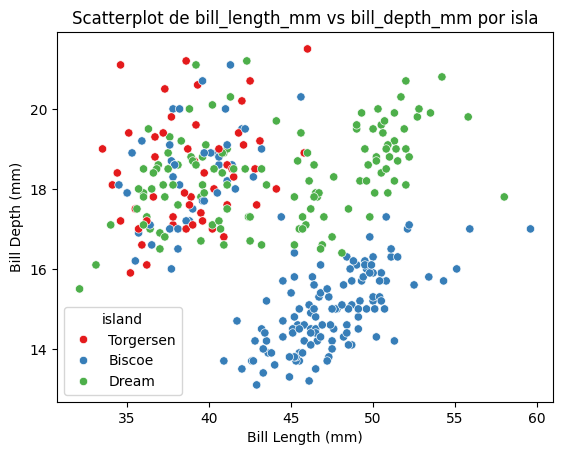

In [6]:
sns.scatterplot(
    data=DatasetLabel,
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="island",
    palette="Set1"
)
plt.title("Scatterplot de bill_length_mm vs bill_depth_mm por isla")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Bill Depth (mm)")
plt.show()

<div class="alert alert-success", role="alert">
    <h1 style="font-size: 1.5em;">Parte 1 </h1>
    <h2 style="font-size: 1.5em; "><strong>Clustering Jerárquico</strong></h2>
</div>

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering

## **[4]** Seleccione las columnas numéricas de su dataset de pinguinos y normalize estos valores
En este laboratorio se hará referencia a este dataset con el nombre de Dataset2D

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar solo las columnas numéricas del DataFrame df_penguins
numeric_cols = df_penguins.select_dtypes(include=[np.number]).columns

Dataset2D = df_penguins[numeric_cols]

# Normalizar los valores numéricos usando MinMaxScaler
scaler = MinMaxScaler()
Dataset2D = pd.DataFrame(scaler.fit_transform(Dataset2D), columns=numeric_cols, index=df_penguins.index)

Dataset2D.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,0.254545,0.666667,0.152542,0.291667,0.0
1,0.269091,0.511905,0.237288,0.305556,0.0
2,0.298182,0.583333,0.389831,0.152778,0.0
4,0.167273,0.738095,0.355932,0.208333,0.0
5,0.261818,0.892857,0.305085,0.263889,0.0


## **[5]** Genere un dendrograma para el Dataset2D

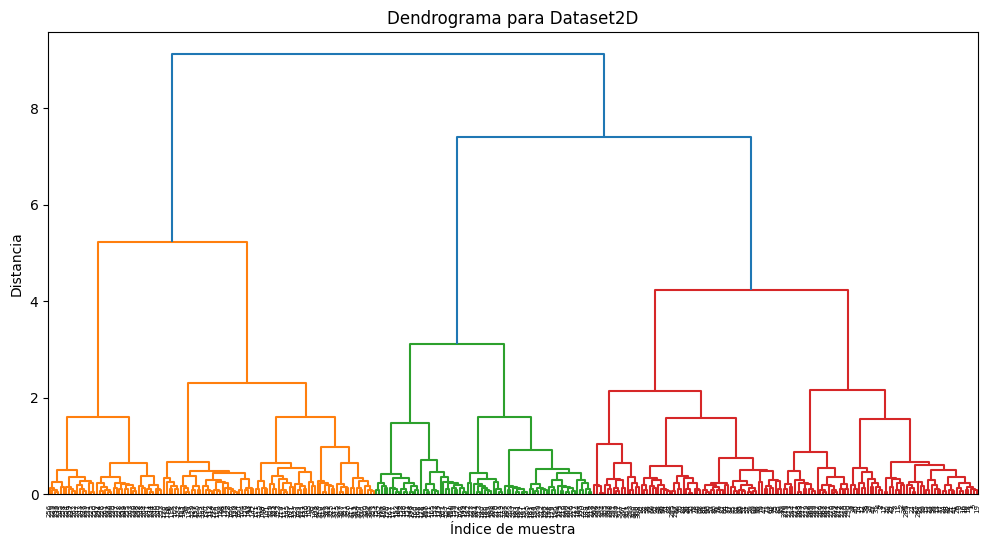

In [9]:
# Calcular el linkage para el dendrograma
linked = linkage(Dataset2D, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(12, 6))
dendrogram(linked)
plt.title("Dendrograma para Dataset2D")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.show()

## **[6]**  Genere un agrupamiento que tenga grupos con una distancia de 7 u 8 unidades

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Usamos el linkage ya calculado: linked
cluster_labels = fcluster(linked, t=7, criterion='distance')

# Mostrar la cantidad de clusters encontrados
n_clusters = len(np.unique(cluster_labels))
print(f"Cantidad de clusters formados con distancia de corte 7: {n_clusters}")

# Guardar los labels para usarlos en las siguientes celdas
agglo_labels = cluster_labels

Cantidad de clusters formados con distancia de corte 7: 3


## **[7]** Presente un scatterplot para este agrupamiento 

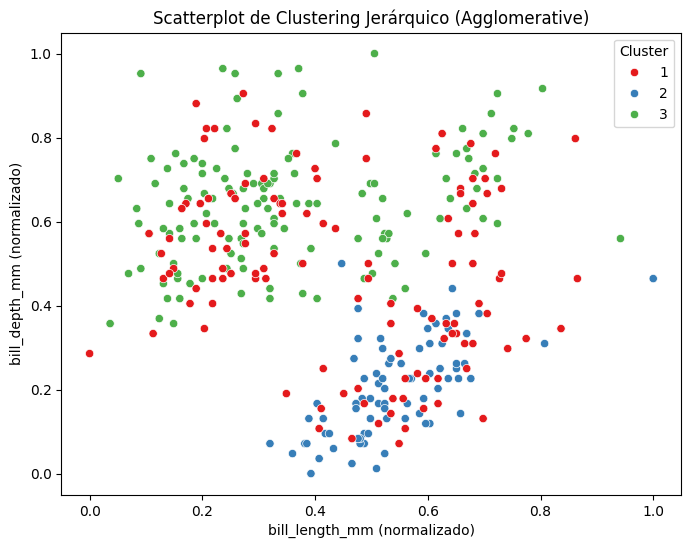

In [12]:
# Usar las dos primeras columnas numéricas para el scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=Dataset2D['bill_length_mm'],
    y=Dataset2D['bill_depth_mm'],
    hue=agglo_labels,
    palette='Set1',
    legend='full'
)
plt.title("Scatterplot de Clustering Jerárquico (Agglomerative)")
plt.xlabel("bill_length_mm (normalizado)")
plt.ylabel("bill_depth_mm (normalizado)")
plt.legend(title="Cluster")
plt.show()

## **[8]** Presente la Grafica y Coeficiente de la silueta para esta agrupación

Coeficiente de Silueta Promedio: 0.381


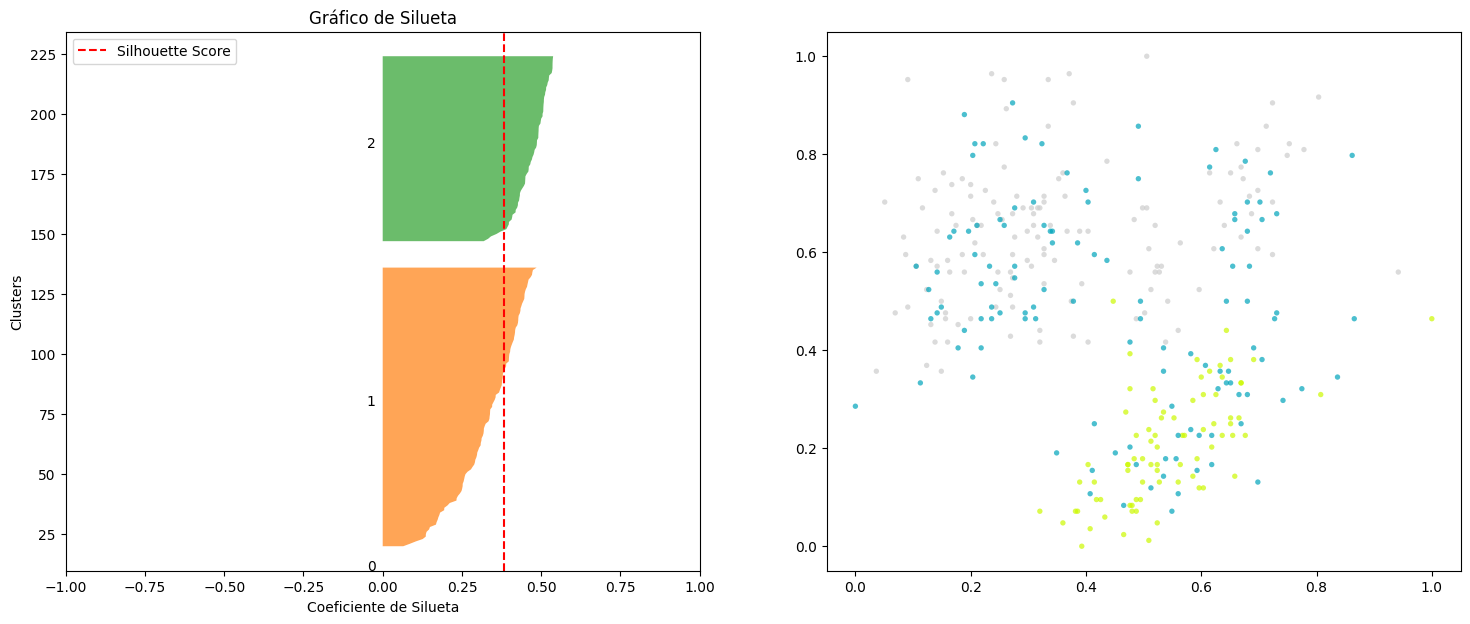

<Figure size 800x500 with 0 Axes>

In [13]:
# Gráfica y coeficiente de silueta para el agrupamiento jerárquico
graficaSilueta(Dataset2D.values, agglo_labels, n_clusters)

<div class="alert alert-success", role="alert">
    <h1 style="font-size: 1.5em;">Parte 2 </h1>
    <h2 style="font-size: 1.5em; "><strong>KMeans</strong></h2>
</div>

In [15]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## **[9]** Usando el mismo dataset2D determine el mejor valor de K y presente la gráfica

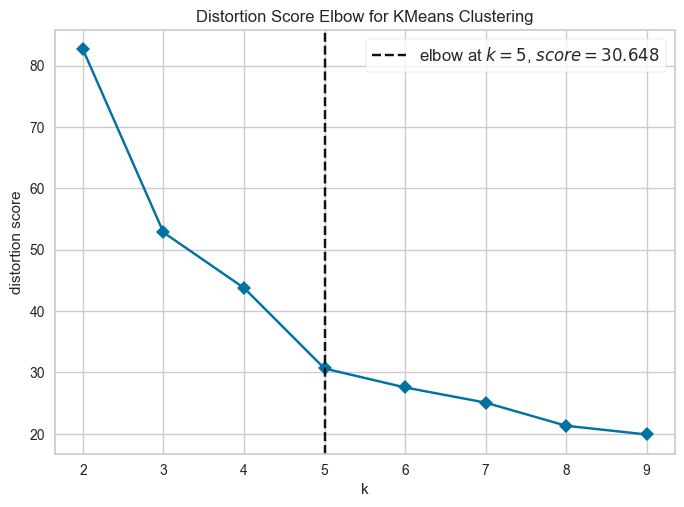

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Usar el método del codo para determinar el mejor valor de K
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(Dataset2D)
visualizer.show()

## **[10]** Tomando en cuenta el valor de K identificado, realice el agrupamiento 

In [19]:
# Realizar el agrupamiento KMeans usando el mejor valor de K identificado
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(Dataset2D)

# Guardar los labels para usarlos en las siguientes celdas
kmeans_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## **[11]** Presente un scatterplot para este agrupamiento

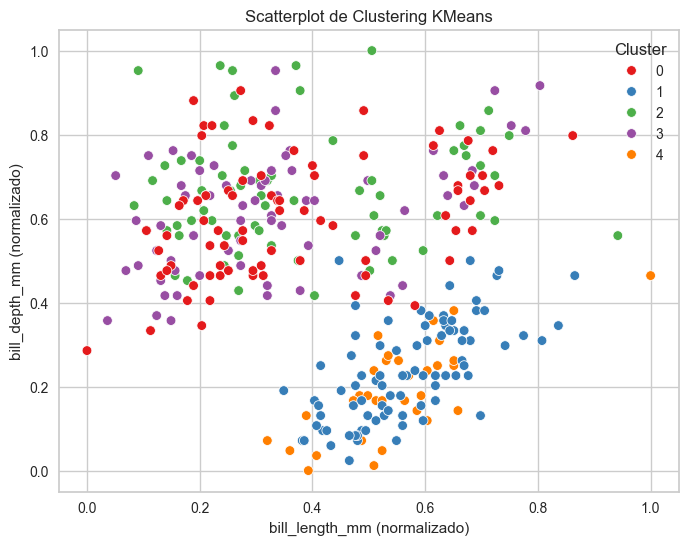

In [ ]:
# Scatterplot para el agrupamiento KMeans
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=Dataset2D['bill_length_mm'],
    y=Dataset2D['bill_depth_mm'],
    hue=kmeans_labels, # mejor valor de K utilizando el metodo del codo.
    palette='Set1',
    legend='full'
)
plt.title("Scatterplot de Clustering KMeans")
plt.xlabel("bill_length_mm (normalizado)")
plt.ylabel("bill_depth_mm (normalizado)")
plt.legend(title="Cluster")
plt.show()

## **[12]** Presente la Grafica y Coeficiente de la silueta para esta agrupación

Coeficiente de Silueta Promedio: 0.409


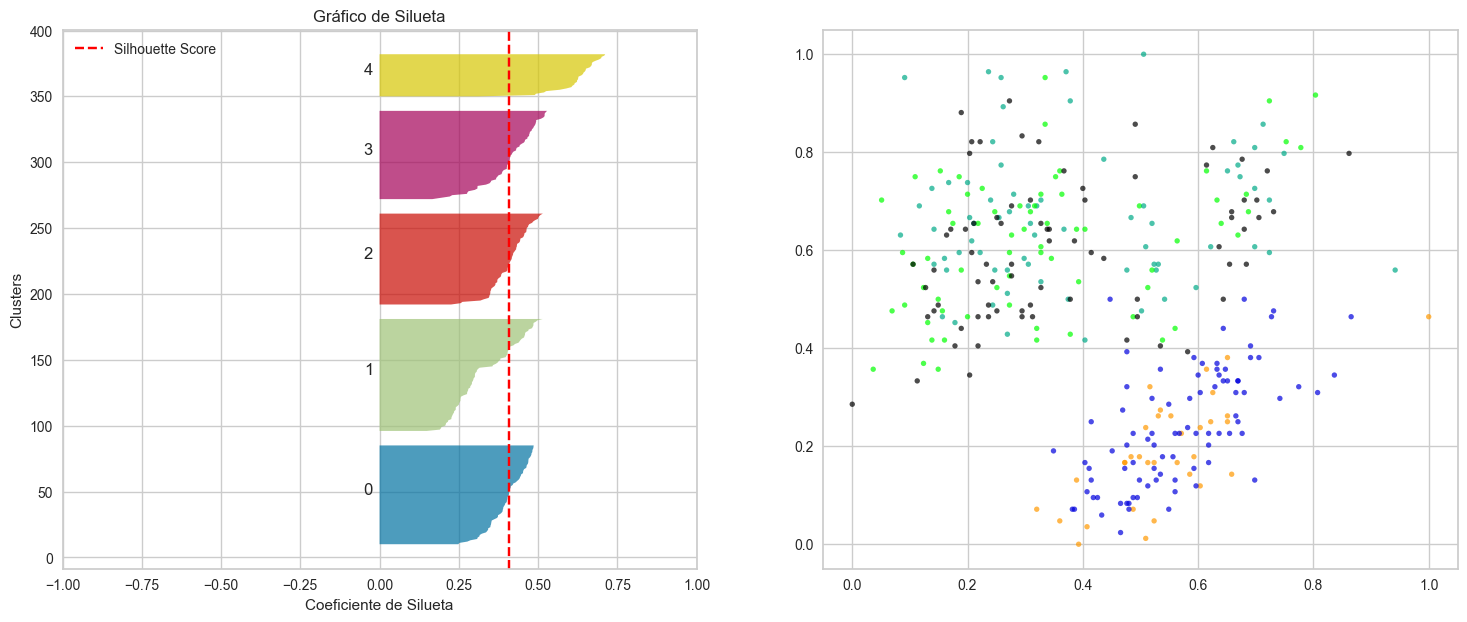

<Figure size 800x500 with 0 Axes>

In [21]:
# Gráfica y coeficiente de silueta para el agrupamiento KMeans
graficaSilueta(Dataset2D.values, kmeans_labels, kmeans.n_clusters)

<div class="alert alert-success", role="alert">
    <h1 style="font-size: 1.5em;">Parte 3 </h1>
    <h2 style="font-size: 1.5em; "><strong>DBSCAN</strong></h2>
</div>

In [22]:
%pip install kneed

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from sklearn.cluster import DBSCAN
from kneed import KneeLocator

## **[13]** Utilice el método de KneeLocator para encontrar el mejor valor de EPS para el Dataset2D y presente su gráfica

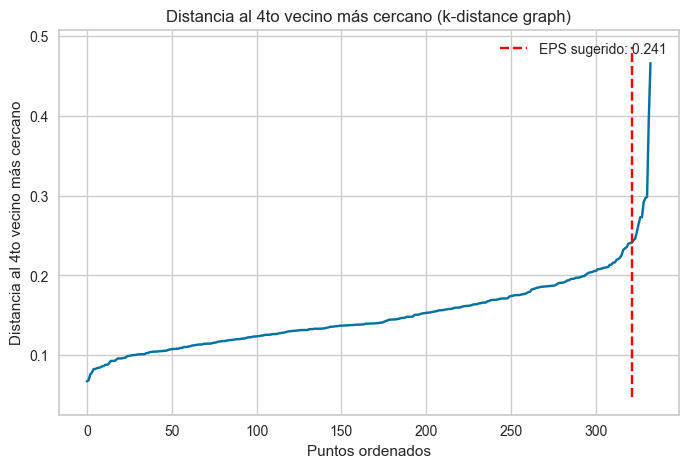

In [25]:
from sklearn.neighbors import NearestNeighbors

# Calcular la distancia al vecino más cercano para cada punto
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(Dataset2D)
distances, indices = neighbors_fit.kneighbors(Dataset2D)

# Ordenar las distancias del 4to vecino más cercano (índice 4)
distances_4th = np.sort(distances[:, 4])

plt.figure(figsize=(8, 5))
plt.plot(distances_4th)
plt.title("Distancia al 4to vecino más cercano (k-distance graph)")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 4to vecino más cercano")

# Usar KneeLocator para encontrar el codo (mejor valor de eps)
kneedle = KneeLocator(
    range(len(distances_4th)), distances_4th, S=1.0, curve="convex", direction="increasing"
)
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red', label=f"EPS sugerido: {distances_4th[kneedle.knee]:.3f}")
plt.legend()
plt.show()


In [27]:
print(f"Mejor valor de EPS sugerido por KneeLocator: {distances_4th[kneedle.knee]:.3f}")

Mejor valor de EPS sugerido por KneeLocator: 0.241


## **[14]** Genere un agrupamiento mediante DBSCAN usando el valor encontrado

In [28]:
# Aplicar DBSCAN usando el mejor valor de eps encontrado por KneeLocator
best_eps = distances_4th[kneedle.knee]
dbscan = DBSCAN(eps=best_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(Dataset2D)

# Guardar los labels para usarlos en las siguientes celdas
dbscan_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3, -1,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  5,  5

## **[15]** Indique la cantidad de cluster y datos ruido identificados

In [30]:
# Contar la cantidad de clusters (excluyendo el ruido, que es -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Contar la cantidad de datos clasificados como ruido
n_noise_dbscan = np.sum(dbscan_labels == -1)

print(f"Cantidad de clusters identificados por DBSCAN: {n_clusters_dbscan}")
print(f"Cantidad de datos clasificados como ruido: {n_noise_dbscan}")

Cantidad de clusters identificados por DBSCAN: 6
Cantidad de datos clasificados como ruido: 3


## **[16]** Presente un scatterplot de esta agrupación

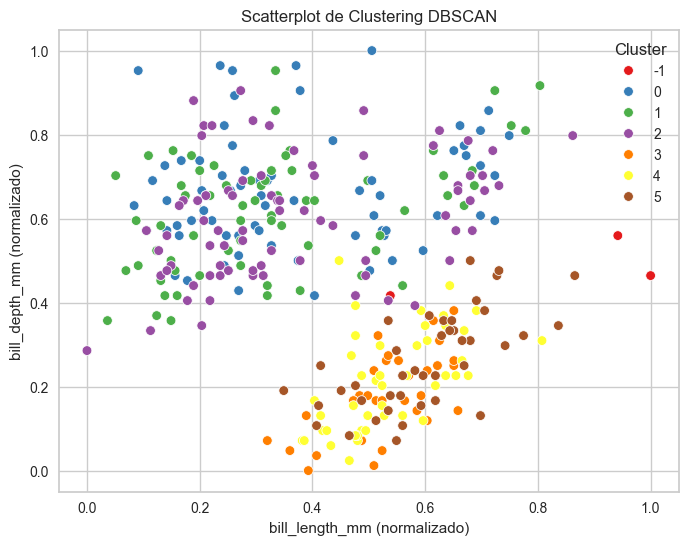

In [31]:
# Scatterplot para la agrupación DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=Dataset2D['bill_length_mm'],
    y=Dataset2D['bill_depth_mm'],
    hue=dbscan_labels,
    palette='Set1',
    legend='full'
)
plt.title("Scatterplot de Clustering DBSCAN")
plt.xlabel("bill_length_mm (normalizado)")
plt.ylabel("bill_depth_mm (normalizado)")
plt.legend(title="Cluster")
plt.show()

## **[17]** Presente la Grafica y Coeficiente de la silueta para esta agrupación

Coeficiente de Silueta Promedio: 0.431


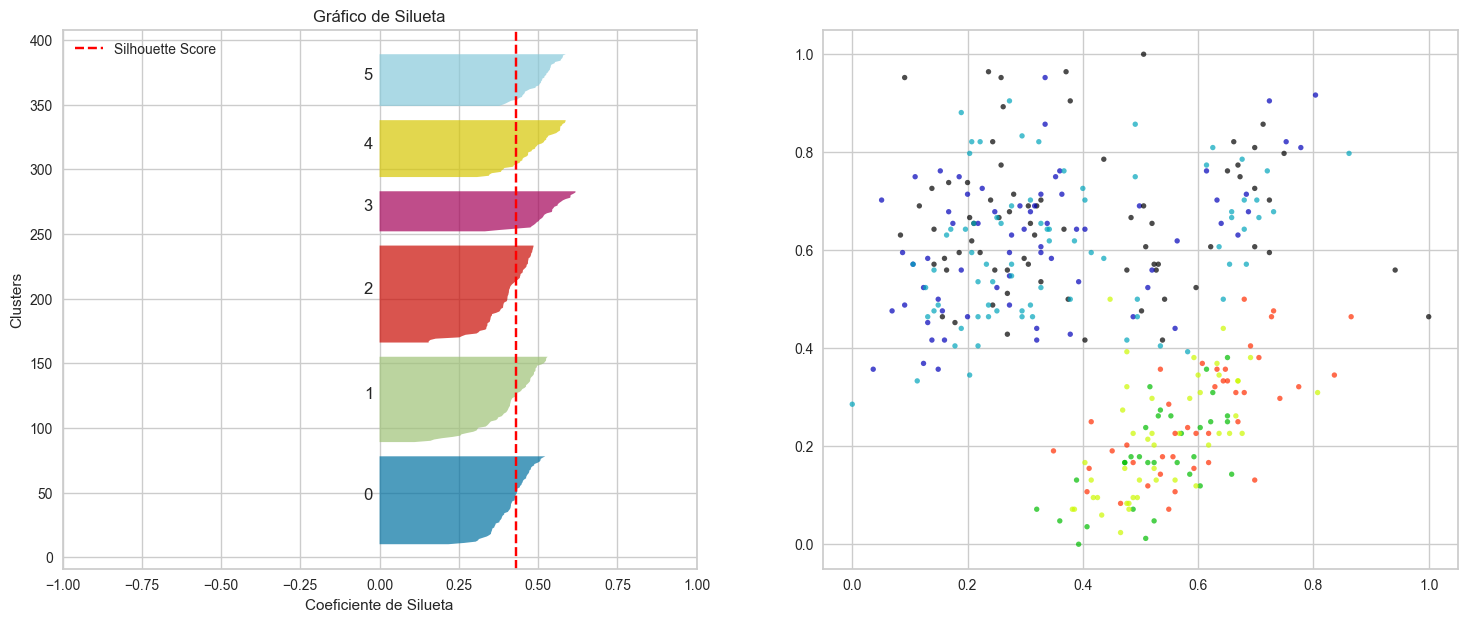

<Figure size 800x500 with 0 Axes>

In [32]:
# Gráfica y coeficiente de silueta para el agrupamiento DBSCAN
graficaSilueta(Dataset2D.values, dbscan_labels, n_clusters_dbscan)

## **[18]** Genere un dataframe que contenga solo la columna species, island, bill_depth_mm y bill_length_mm del dataset original de pinguinos
En este laboratorio se hará referencia a este dataset con el nombre de DatasetPeng2

In [33]:
# Crear el DataFrame solicitado con las columnas indicadas
DatasetPeng2 = df_penguins[['species', 'island', 'bill_depth_mm', 'bill_length_mm']]
DatasetPeng2.head()

,species,island,bill_depth_mm,bill_length_mm
0,Adelie,Torgersen,18.7,39.1
1,Adelie,Torgersen,17.4,39.5
2,Adelie,Torgersen,18.0,40.3
4,Adelie,Torgersen,19.3,36.7
5,Adelie,Torgersen,20.6,39.3


## **[19]** Usando DatasetPeng2 genere un dataframe que solo contenga la parte numérica del dataset con el nombre pengNumeric, genere también 2 listas que contengan el valor de la columna species e island, llamelas ySpecies, yIsland respectivamente

In [34]:
# Extraer solo las columnas numéricas de DatasetPeng2
pengNumeric = DatasetPeng2.select_dtypes(include=[np.number])

# Extraer las listas de species e island
ySpecies = DatasetPeng2['species'].tolist()
yIsland = DatasetPeng2['island'].tolist()

pengNumeric.head()

,bill_depth_mm,bill_length_mm
0,18.7,39.1
1,17.4,39.5
2,18.0,40.3
4,19.3,36.7
5,20.6,39.3


## **[20]** Busque cual es el mejor valor de EPS para el dataset pengNumeric

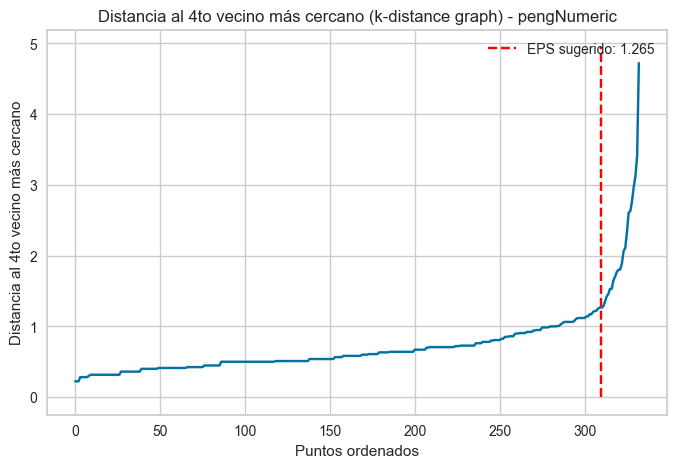

Mejor valor de EPS sugerido por KneeLocator para pengNumeric: 1.265


In [35]:
from sklearn.neighbors import NearestNeighbors

# Calcular la distancia al vecino más cercano para cada punto en pengNumeric
neighbors_peng = NearestNeighbors(n_neighbors=5)
neighbors_peng_fit = neighbors_peng.fit(pengNumeric)
distances_peng, indices_peng = neighbors_peng_fit.kneighbors(pengNumeric)

# Ordenar las distancias del 4to vecino más cercano (índice 4)
distances_peng_4th = np.sort(distances_peng[:, 4])

plt.figure(figsize=(8, 5))
plt.plot(distances_peng_4th)
plt.title("Distancia al 4to vecino más cercano (k-distance graph) - pengNumeric")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 4to vecino más cercano")

# Usar KneeLocator para encontrar el codo (mejor valor de eps)
kneedle_peng = KneeLocator(
    range(len(distances_peng_4th)), distances_peng_4th, S=1.0, curve="convex", direction="increasing"
)
plt.vlines(kneedle_peng.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red', label=f"EPS sugerido: {distances_peng_4th[kneedle_peng.knee]:.3f}")
plt.legend()
plt.show()

print(f"Mejor valor de EPS sugerido por KneeLocator para pengNumeric: {distances_peng_4th[kneedle_peng.knee]:.3f}")

## **[21]** Aplique DBSCAN para el dataset pengNumeric

In [38]:
# Aplicar DBSCAN usando el mejor valor de eps encontrado por KneeLocator para pengNumeric
best_eps_peng = distances_peng_4th[kneedle_peng.knee]
dbscan_peng = DBSCAN(eps=best_eps_peng, min_samples=5)
dbscan_peng_labels = dbscan_peng.fit_predict(pengNumeric)

# Guardar los labels para usarlos en las siguientes celdas
dbscan_peng_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## **[22]** Presente un scatterplot de esta agrupación

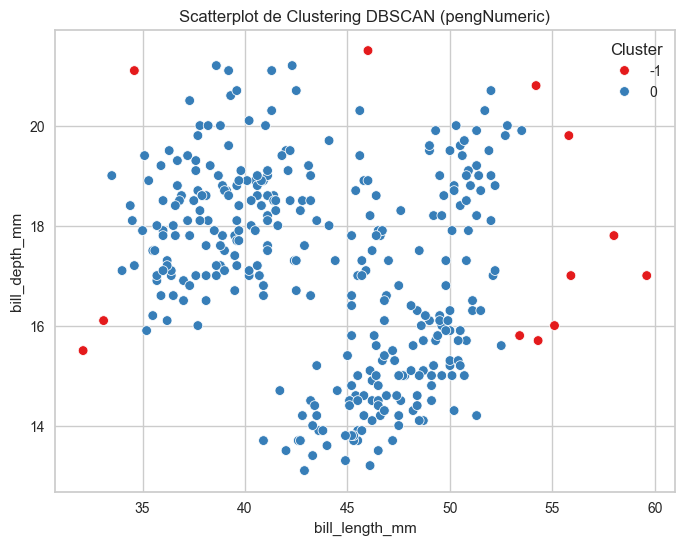

In [39]:
# Scatterplot para la agrupación DBSCAN sobre pengNumeric
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pengNumeric['bill_length_mm'],
    y=pengNumeric['bill_depth_mm'],
    hue=dbscan_peng_labels,
    palette='Set1',
    legend='full'
)
plt.title("Scatterplot de Clustering DBSCAN (pengNumeric)")
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.legend(title="Cluster")
plt.show()

<div class="alert alert-success", role="alert">
    <h1 style="font-size: 1.5em;">Parte 4 </h1>
    <h2 style="font-size: 1.5em; "><strong>PCA</strong></h2>
</div>

In [42]:
import tensorflow as tf

In [40]:
# Función para generar un scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF, index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [43]:
# Cargar Dataset Fashion MNIST 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train = np.reshape(X_train, (60000,784))
X_test = np.reshape(X_test, (10000, 784))

# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
test_index = range(len(X_train), len(X_train)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)


labels_dict = {
    0: "tshirt",
    1: "pants",
    2: "sweater",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "dressshirt",
    7: "sneaker",
    8: "bag",
    9: "ankleboot",
}
# Etiquetas de las instancias
y_train_labels = y_train.map(labels_dict)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## **[23]** Aplique PCA para que la reducción de dimensiones mantenga el 90% de la Varianza

In [45]:
from sklearn.decomposition import PCA

var_reduc = .90

# Aplicar PCA para mantener el 90% de la varianza en X_train
pca_90 = PCA(n_components=var_reduc, svd_solver='full')
X_train_pca_90 = pca_90.fit_transform(X_train)

# Mostrar la forma del nuevo dataset reducido
print(f"Forma de X_train después de PCA (90% varianza): {X_train_pca_90.shape}")

Forma de X_train después de PCA (90% varianza): (60000, 84)


## **[24]** Indique la cantidad de dimensiones a las que se redujo el dataset

In [51]:
original_dim = X_train.shape[1]
reduced_dim = X_train_pca_90.shape[1]
diff_dim = original_dim - reduced_dim

# Mostrar la cantidad de dimensiones originales y después de aplicar PCA con 90% de varianza
print(f"Cantidad de dimensiones originales: {original_dim}")

# Mostrar la cantidad de dimensiones después de aplicar PCA con 90% de varianza
print(f"Cantidad de dimensiones después de PCA (90% varianza): {reduced_dim}")

print(f"Diferencia de dimensiones: {diff_dim}")

Cantidad de dimensiones originales: 784
Cantidad de dimensiones después de PCA (90% varianza): 84
Diferencia de dimensiones: 700


## **[25]** Determine mediante Explanied Variance Ratio cual es la cantidad de dimensiones que mantienen el $92%$ de la varianza

In [53]:
threshold = 0.92

# Calcular la cantidad de componentes necesarias para mantener el 92% de la varianza
pca_full = PCA().fit(X_train)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_92 = np.argmax(cumulative_variance >= threshold) + 1

print(f"Cantidad de dimensiones que mantienen el 92% de la varianza: {n_components_92}")

Cantidad de dimensiones que mantienen el 92% de la varianza: 113


## **[26]** Presente la gráfica para el análisis anterior

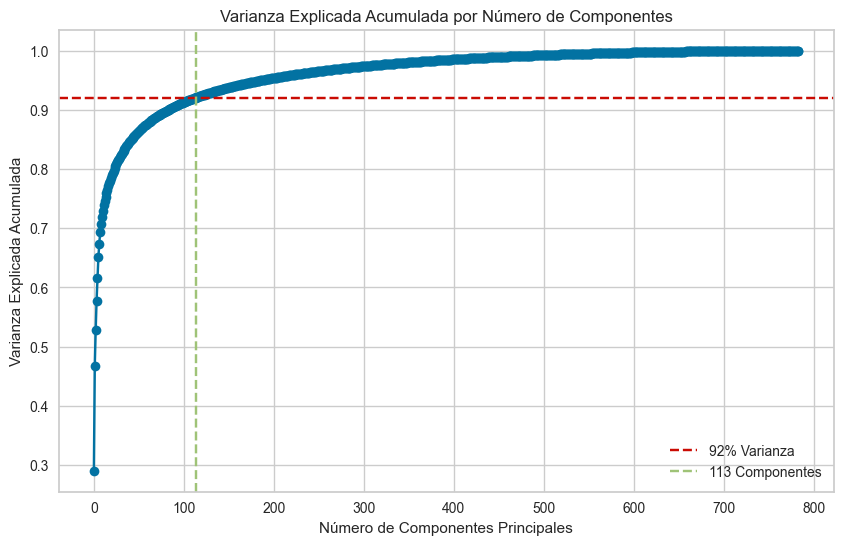

In [54]:
# Gráfica de la varianza explicada acumulada para los componentes principales
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold*100)}% Varianza')
plt.axvline(x=n_components_92, color='g', linestyle='--', label=f'{n_components_92} Componentes')
plt.title('Varianza Explicada Acumulada por Número de Componentes')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True)
plt.show()

## **[27]** Reduzca el dataset a 2 dimensiones utilizando PCA

In [61]:
# Aplicar PCA para reducir el dataset X_train a 2 dimensiones
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train)

# Mostrar la forma del nuevo dataset reducido
print(f"Forma de X_train después de PCA (2 dimensiones): {X_train_pca_2d.shape}")

Forma de X_train después de PCA (2 dimensiones): (60000, 2)


## **[28]** Genere un Dataframe con las nuevas dimensiones

In [63]:
# Crear un DataFrame con las dos nuevas dimensiones obtenidas por PCA
df_pca_2d = pd.DataFrame(X_train_pca_2d, columns=['PC1', 'PC2'], index=X_train.index)
df_pca_2d.head()

,PC1,PC2
0,-123.993791,1633.074396
1,1407.928853,-451.641336
2,-725.910795,-1101.838138
3,31.398664,-981.067672
4,804.119258,-1201.168720


## **[29]** Genere un scatterplot con el dataframe anterior

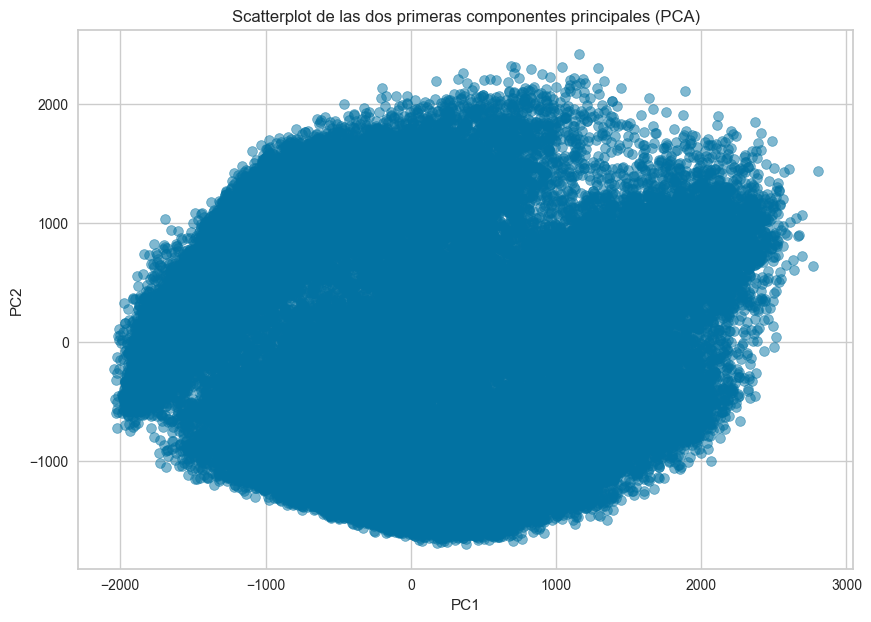

In [64]:
# Scatterplot de las dos primeras componentes principales obtenidas por PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_pca_2d,
    x='PC1',
    y='PC2',
    alpha=0.5,
    edgecolor=None
)
plt.title("Scatterplot de las dos primeras componentes principales (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

<div class="alert alert-success", role="alert">
    <h1 style="font-size: 1.5em;">Parte 5 </h1>
    <h2 style="font-size: 1.5em; "><strong>PCA + Penguins</strong></h2>
</div>

## **[30]** Esta sección utilizará los datasets pengNumeric, ySpecies, yIsland. Genere una representación de 2 dimensiones para pengNumeric

In [65]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir pengNumeric a 2 dimensiones
pca_penguins_2d = PCA(n_components=2)
pengNumeric_pca_2d = pca_penguins_2d.fit_transform(pengNumeric)

## **[31]** Genere un Dataframe con las nuevas dimensiones 

In [66]:
# Crear un DataFrame con las dos nuevas dimensiones obtenidas por PCA para pengNumeric
df_pengNumeric_pca_2d = pd.DataFrame(pengNumeric_pca_2d, columns=['PC1', 'PC2'], index=pengNumeric.index)
df_pengNumeric_pca_2d.head()

,PC1,PC2
0,-5.014734,1.071683
1,-4.495124,-0.185300
2,-3.754628,0.486761
4,-7.460265,1.445020
5,-4.992975,2.982056


## **[32]** Utilizando la reducción con PCA presente un ScatterPlot usando la ySpecies como etiqueta
*Obs* Puede usar la función que utilizó en la sección anterior.

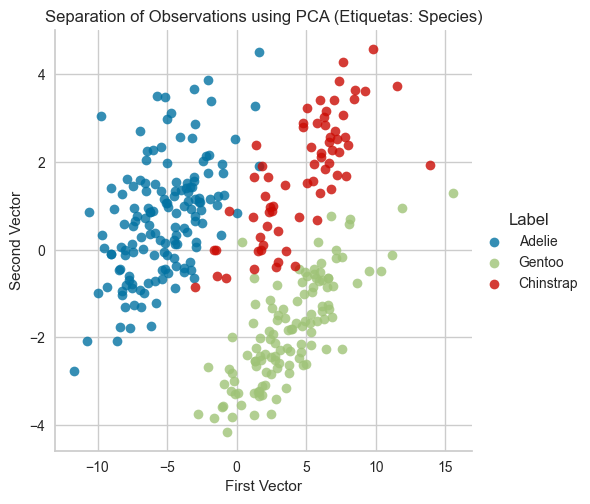

In [67]:
# Usar la función scatterPlot definida anteriormente para graficar las dos dimensiones de PCA con ySpecies como etiqueta
scatterPlot(
    pd.DataFrame(pengNumeric_pca_2d, columns=['PC1', 'PC2']),
    pd.Series(ySpecies, name='Label'),
    "PCA (Etiquetas: Species)"
)

## **[33]** Utilizando la reducción con PCA presente un ScatterPlot usando la yIsland como etiqueta

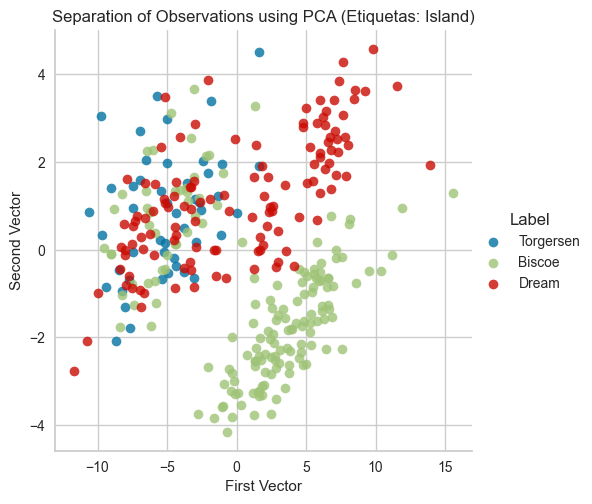

In [68]:
# Usar la función scatterPlot definida anteriormente para graficar las dos dimensiones de PCA con yIsland como etiqueta
scatterPlot(
    pd.DataFrame(pengNumeric_pca_2d, columns=['PC1', 'PC2']),
    pd.Series(yIsland, name='Label'),
    "PCA (Etiquetas: Island)"
)

## **[34]** Utilizando la reducción con PCA realice un clustering con kmeans y presente el diagrama de Voronoi para el agrupamiento resultante.
Obs. Se recomenienda convertir el dataframe PCA a un arreglo (DF.to_numpy())

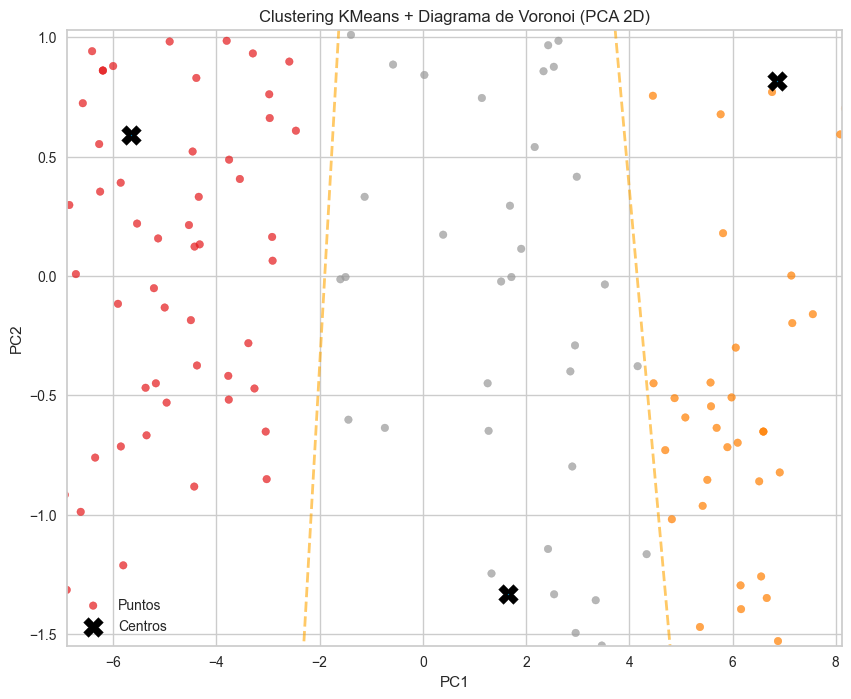

In [70]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Realizar clustering KMeans sobre las dos dimensiones de PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42)
labels_pca = kmeans_pca.fit_predict(pengNumeric_pca_2d)

# Graficar el diagrama de Voronoi
plt.figure(figsize=(10, 8))
vor = Voronoi(kmeans_pca.cluster_centers_)
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)

# Graficar los puntos y los centros de los clusters
plt.scatter(
    pengNumeric_pca_2d[:, 0], pengNumeric_pca_2d[:, 1],
    c=labels_pca, cmap='Set1', s=30, alpha=0.7, label='Puntos'
)
plt.scatter(
    kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1],
    c='black', s=200, marker='X', label='Centros'
)
plt.title("Clustering KMeans + Diagrama de Voronoi (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

## **[35]** Comentarios Finales